Imports & setup

In [13]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import pandas as pd


In [2]:
sns.set(style="whitegrid")
RESULTS_DIR = Path("../results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)

Load data (clean, with target kept for later comparison)

In [3]:
df = pd.read_csv("../data/heart_disease_clean.csv")
target_col = "target"
X = df.drop(columns=[target_col])
y = df[target_col].copy()

print("Data:", X.shape, " Target distribution:\n", y.value_counts(normalize=True).round(3))


Data: (303, 13)  Target distribution:
 target
0    0.541
1    0.459
Name: proportion, dtype: float64


Preprocessing for UNSUPERVISED (no target leakage)


In [4]:
# Explicit types (even if numerics in CSV):
possible_cats = ["sex","cp","fbs","restecg","exang","slope","thal","ca"]
cat_cols = [c for c in possible_cats if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

# Dense OHE is convenient for KMeans
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
    ],
    remainder="drop"
)

X_mat = pre.fit_transform(X)  # dense matrix
X_mat.shape


(303, 28)

 PCA, this is only for visualization


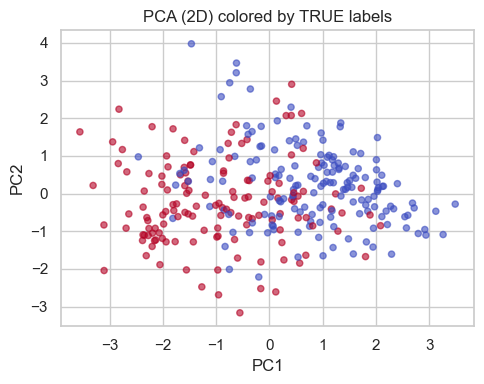

In [5]:
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_mat)

plt.figure(figsize=(5,4))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap="coolwarm", alpha=0.6, s=20)
plt.title("PCA (2D) colored by TRUE labels")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()


K-Means — elbow & silhouette, pick K by best silhouette


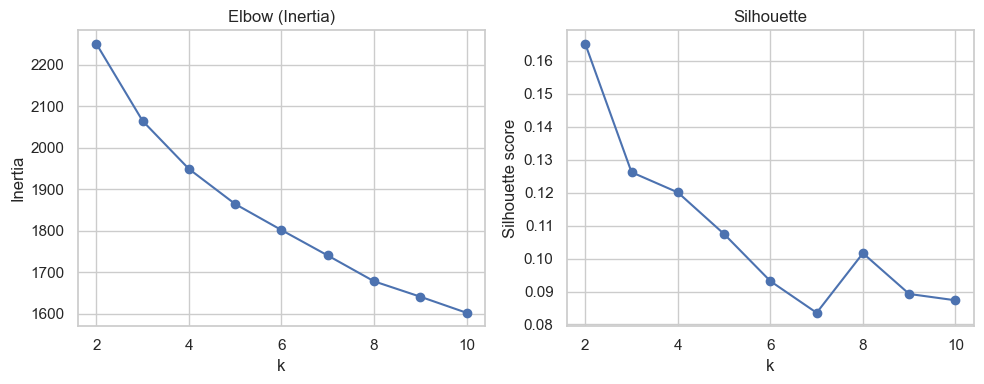

Auto-selected k by silhouette: 2


In [6]:
inertias, sils, K = [], [], list(range(2, 11))  # start at 2 for silhouette
for k in K:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_mat)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_mat, labels))

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(K, inertias, marker="o"); ax[0].set_title("Elbow (Inertia)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")
ax[1].plot(K, sils, marker="o"); ax[1].set_title("Silhouette")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette score")
plt.tight_layout(); plt.show()

k_best = K[int(np.argmax(sils))]
print(f"Auto-selected k by silhouette: {k_best}")


Fit final K-Means and compare to labels


KMeans vs True labels:
 - Adjusted Rand Index: 0.273
 - Normalized Mutual Info: 0.206


target,0,1
cluster,,
0,35,102
1,129,37


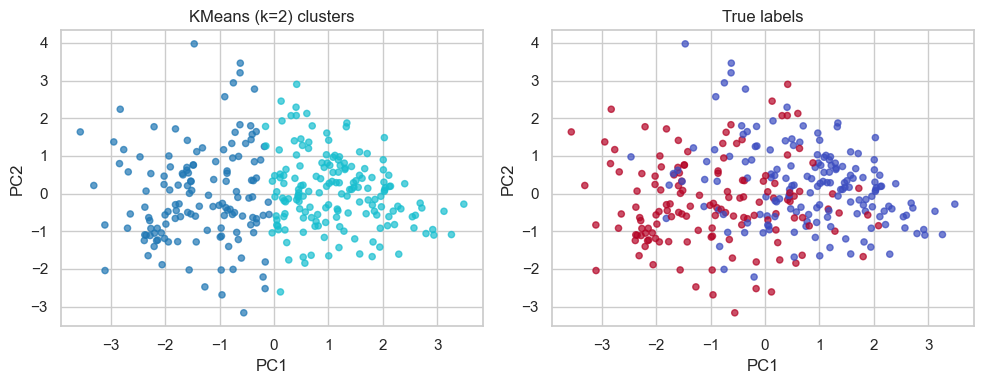

In [7]:
kmeans = KMeans(n_clusters=k_best, n_init=20, random_state=42)
clusters_km = kmeans.fit_predict(X_mat)

# Metrics vs true labels (note: cluster labels are arbitrary)
ari_km  = adjusted_rand_score(y, clusters_km)
nmi_km  = normalized_mutual_info_score(y, clusters_km)
ct_km   = pd.crosstab(clusters_km, y, rownames=["cluster"], colnames=["target"])

print("KMeans vs True labels:")
print(" - Adjusted Rand Index:", round(ari_km, 3))
print(" - Normalized Mutual Info:", round(nmi_km, 3))
display(ct_km)

# Visualize clusters in PCA space
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(X_2d[:,0], X_2d[:,1], c=clusters_km, cmap="tab10", alpha=0.7, s=20)
ax[0].set_title(f"KMeans (k={k_best}) clusters")
ax[0].set_xlabel("PC1"); ax[0].set_ylabel("PC2")

ax[1].scatter(X_2d[:,0], X_2d[:,1], c=y, cmap="coolwarm", alpha=0.7, s=20)
ax[1].set_title("True labels")
ax[1].set_xlabel("PC1"); ax[1].set_ylabel("PC2")
plt.tight_layout(); plt.show()


Hierarchical – dendrogram, this is subset for readability


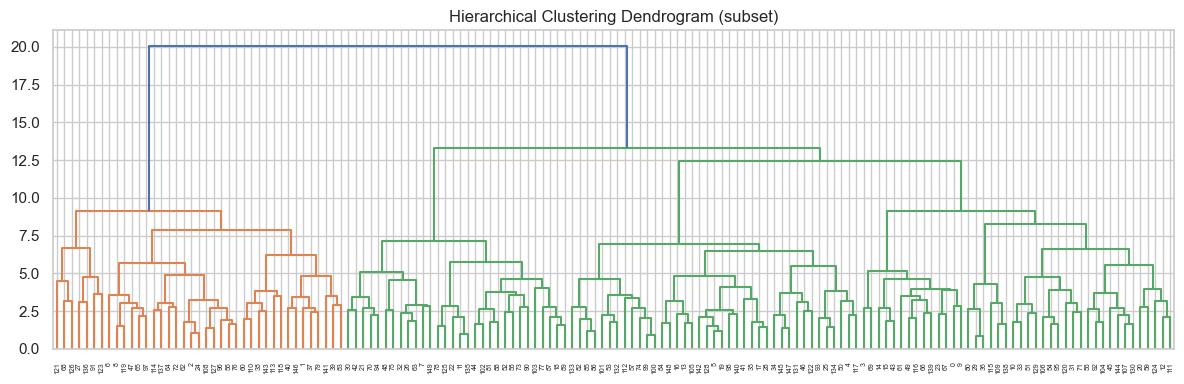

In [ ]:
sub_n = min(150, X_mat.shape[0])
Z = linkage(X_mat[:sub_n], method="ward")

plt.figure(figsize=(12,4))
dendrogram(Z, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (subset)")
plt.tight_layout(); plt.show()


Agglomerative clustering (to get labels) and comparison


Agglomerative vs True labels:
 - Adjusted Rand Index: 0.219
 - Normalized Mutual Info: 0.224


target,0,1
cluster,,
0,157,73
1,7,66


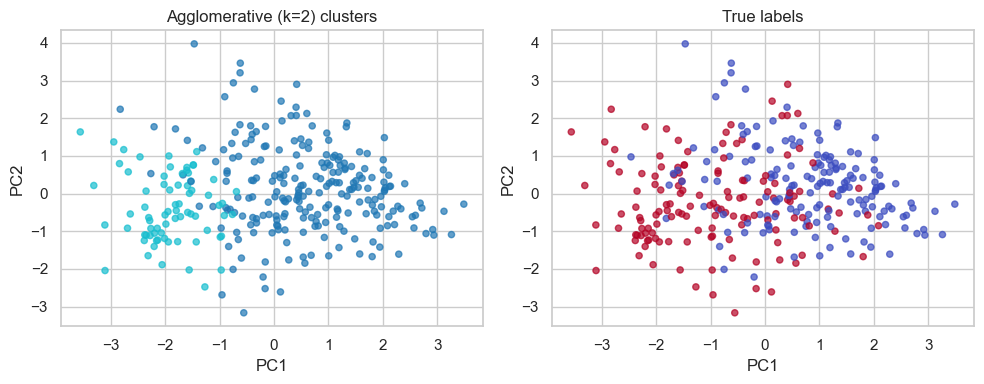

In [9]:
agg = AgglomerativeClustering(n_clusters=k_best, linkage="ward")
clusters_ag = agg.fit_predict(X_mat)

ari_ag  = adjusted_rand_score(y, clusters_ag)
nmi_ag  = normalized_mutual_info_score(y, clusters_ag)
ct_ag   = pd.crosstab(clusters_ag, y, rownames=["cluster"], colnames=["target"])

print("Agglomerative vs True labels:")
print(" - Adjusted Rand Index:", round(ari_ag, 3))
print(" - Normalized Mutual Info:", round(nmi_ag, 3))
display(ct_ag)

# Visualize
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(X_2d[:,0], X_2d[:,1], c=clusters_ag, cmap="tab10", alpha=0.7, s=20)
ax[0].set_title(f"Agglomerative (k={k_best}) clusters")
ax[0].set_xlabel("PC1"); ax[0].set_ylabel("PC2")

ax[1].scatter(X_2d[:,0], X_2d[:,1], c=y, cmap="coolwarm", alpha=0.7, s=20)
ax[1].set_title("True labels")
ax[1].set_xlabel("PC1"); ax[1].set_ylabel("PC2")
plt.tight_layout(); plt.show()


In [14]:
print("Silhouette@k_best (KMeans):", round(silhouette_score(X_mat, clusters_km), 3))

print("\nKMeans vs true labels:")
print("  ARI:", round(adjusted_rand_score(y, clusters_km), 3))
print("  NMI:", round(normalized_mutual_info_score(y, clusters_km), 3))
display(pd.crosstab(clusters_km, y, rownames=["cluster"], colnames=["target"]))

print("\nAgglomerative vs true labels:")
print("  ARI:", round(adjusted_rand_score(y, clusters_ag), 3))
print("  NMI:", round(normalized_mutual_info_score(y, clusters_ag), 3))
display(pd.crosstab(clusters_ag, y, rownames=["cluster"], colnames=["target"]))

Silhouette@k_best (KMeans): 0.165

KMeans vs true labels:
  ARI: 0.273
  NMI: 0.206


target,0,1
cluster,,
0,35,102
1,129,37



Agglomerative vs true labels:
  ARI: 0.219
  NMI: 0.224


target,0,1
cluster,,
0,157,73
1,7,66


Saving


In [10]:
assignments = pd.DataFrame({
    "cluster_kmeans": clusters_km,
    "cluster_agglomerative": clusters_ag,
    "target": y.values
}, index=df.index)
assignments.to_csv(RESULTS_DIR / "unsupervised_cluster_assignments.csv", index=True)

print("Saved cluster assignments to ../results/unsupervised_cluster_assignments.csv")
print("Figures visible above; export from notebook if needed for your report.")


Saved cluster assignments to ../results/unsupervised_cluster_assignments.csv
Figures visible above; export from notebook if needed for your report.


In [11]:
plt.gcf().savefig("../results/kmeans_elbow.png", dpi=150, bbox_inches="tight")
plt.gcf().savefig("../results/kmeans_silhouette.png", dpi=150, bbox_inches="tight")
plt.gcf().savefig("../results/pca_clusters_kmeans_vs_true.png", dpi=150, bbox_inches="tight")
plt.gcf().savefig("../results/hierarchical_dendrogram.png", dpi=150, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>